In [5]:
import pandas as pd
import numpy as np
import requests
import json
import time


#df = pd.read_csv("Poloniex_ETHBTC_1h.csv")
#df.head()
full_dict = []
month = 3600*24*30
stop = int(time.time())
start = stop - month

testing_dict = []
for i in range(365*3//30):
    print(i, '/', 365*3//30)
    r = requests.get("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start={}&end={}&period=300".format(
    start,stop))
    stop -= month
    start -= month
        
    data_dict = json.loads(r.text)
    full_dict = data_dict + full_dict

df = pd.DataFrame.from_dict(full_dict)
print(df.head())

0 / 36
1 / 36
2 / 36
3 / 36
4 / 36
5 / 36
6 / 36
7 / 36
8 / 36
9 / 36
10 / 36
11 / 36
12 / 36
13 / 36
14 / 36
15 / 36
16 / 36
17 / 36
18 / 36
19 / 36
20 / 36
21 / 36
22 / 36
23 / 36
24 / 36
25 / 36
26 / 36
27 / 36
28 / 36
29 / 36
30 / 36
31 / 36
32 / 36
33 / 36
34 / 36
35 / 36
         date       high        low       open      close       volume  \
0  1492271178  48.115564  48.115564  48.115564  48.115564     0.000000   
1  1492271400  48.145000  48.131966  48.131966  48.145000  1184.557263   
2  1492271700  48.341449  48.114509  48.145000  48.114509  2780.024138   
3  1492272000  48.406840  48.250000  48.250000  48.250840  2624.010773   
4  1492272300  48.398390  48.300910  48.300910  48.398390  3797.902038   

   quoteVolume  weightedAverage  
0     0.000000        48.115564  
1    24.604379        48.144164  
2    57.703092        48.178080  
3    54.257315        48.362341  
4    78.485959        48.389573  


In [6]:
df.shape

(311072, 8)

In [7]:
CLASSES = 'UP', 'DOWN', 'STRAIGHT', 'NS'
UP_VALS = (0.3,10) # if max value of period is upper
DOWN_VALS = (-10, -0.3) # if close value is lower
STRAIGHT_VALS = (-0.0, 0.2) # if close value of 30m is equal to open value
WINDOW_SIZE = 6

price_column = 'open'
normalize_columns = ['mean_10m', 'mean_15m', 'mean_20m', 'mean_40m', 'mean_80m', 'mean_160m']

def process_df(df):
    def mean(column, window):
        column = list(column)
        result = []
        for i in range(window):
            result.append(column[i])
        for i in range(0,len(column) - window):
            result.append(sum(column[i:i+window])/window)
        return result
    df['mean_10m'] = mean(df['open'], 2)
    df['mean_15m'] = mean(df['open'], 8)
    df['mean_20m'] = mean(df['open'], 32)
    df['mean_40m'] = mean(df['open'], 120)
    df['mean_80m'] = mean(df['open'], 480)
    df['mean_160m'] = mean(df['open'], 2000)

    def normalize_column(price_column, normalize_column):
        result_column = []
        for p, n in zip(price_column, normalize_column):
            result_column.append((n/p - 1) * 100)
        return result_column

    for nc in normalize_columns:
        df[nc] = normalize_column(df[price_column], df[nc])
        
    def add_max_next(price_column, window=WINDOW_SIZE):
        y = []

        for i in range(len(price_column)-window):
            max_next = (max(price_column[i:i+window])/price_column[i] - 1) * 100
            y.append(max_next)

        for i in range(window):
            y.append(0)
            
        return y
    
    def add_close_next(price_column, window=WINDOW_SIZE):
        y = []

        for i in range(len(price_column)-window):
            close_next = (price_column[i+window]/price_column[i] - 1) * 100
            y.append(close_next)

        for i in range(window):
            y.append(0)
            
        return y
    
    def add_y(max_column, close_column, window=WINDOW_SIZE):
        y = []
        up = 0
        down = 0
        straight = 0
        ns = 0
        for m, c in zip(max_column, close_column):
            if m > UP_VALS[0]:
                y.append('UP')
                up+=1
                continue
            if c > STRAIGHT_VALS[0]:
                y.append('STRAIGHT')
                straight+=1
                continue
            if c < DOWN_VALS[1]:
                y.append('DOWN')
                down+=1
                continue
            y.append('NS')
            ns+=1
        print("UP {} DOWN {} STRAIGHT {} NS {}".format(up, down, straight, ns))
        return y

    
    df['max_next'] = add_max_next(df[price_column])
    df['close_next'] = add_close_next(df[price_column])
    df['y'] = add_y(df['max_next'], df['close_next'])

    return df

df = process_df(df)



UP 113795 DOWN 70023 STRAIGHT 62304 NS 64950


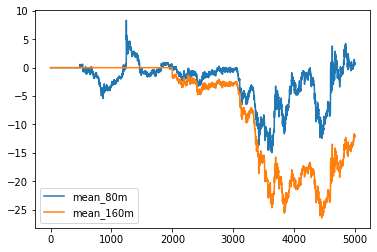

In [8]:
df[['mean_80m', 'mean_160m']].iloc[:5000].plot()
df = df.iloc[2000:]

In [9]:
train_df = df.iloc[:200000]
test_df = df.iloc[200001:]
X_train, y_train = train_df[normalize_columns], train_df['y']
X_test, y_test = test_df[normalize_columns], test_df['y']

import seaborn as sns

#sns.pairplot(test_df[normalize_columns[:5]+['y']], plot_kws={"s": 3})

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


#estimator2 = RandomForestClassifier(n_estimators=100, max_features=5, max_samples=1000)
#estimator2.fit(X_train, y_train)

import pickle
estimator2 = pickle.load(open('../Downloads/upstream_predictor2.pickle', 'rb'))

In [4]:
y_predicted2 = estimator2.predict_proba(X_train)
print(estimator2.classes_)
import pprint
# pprint.pprint([(y_t, y_p) for y_t, y_p in zip(y_test, y_predicted2)])
for upprob in np.arange(0.6,0.8,0.01):
    for downprob in np.arange(0.15,0.20,0.005):
        def predict(predicted, up_prob=upprob,straight_prob=0, downprob=downprob):
            predict_final = []
            for p in predicted:
                predict_final.append(p[3] > up_prob and p[0] < downprob and p[1]+p[2]>straight_prob)
            return predict_final
        y_predicted = predict(y_predicted2)
        dispersion = [y_t for y_t, y_p in zip(y_train, y_predicted) if y_p]
        dispersion = (dispersion.count(estimator2.classes_[0]), dispersion.count(estimator2.classes_[1]), dispersion.count(estimator2.classes_[2]), dispersion.count(estimator2.classes_[3]),)
        try:
            print("ERROR RATE", dispersion[0]/dispersion[3], "TOTAL",dispersion[3] , "PARAM", upprob, downprob)
            if dispersion[0]/dispersion[3] < 0.19:
                print("TRAIN",test_model(train_df.iloc[-20*24*1000:]['open'], train_df.iloc[-20*24*1000:]['high'], train_df.iloc[-20*24*1000:]['low'], predict(estimator2.predict_proba(X_train.iloc[-20*24*1000:])), 0.999,1.007))
                print("TEST",test_model(test_df.iloc[-20*24*1000:]['open'], test_df.iloc[-20*24*1000:]['high'], test_df.iloc[-20*24*1000:]['low'], predict(estimator2.predict_proba(X_test.iloc[-20*24*1000:])), 0.999,1.007))
        except:
            pass

#best 0.64, 0.17


NameError: name 'estimator2' is not defined

In [11]:
def predict(predicted, up_prob=0.64,straight_prob=0, downprob=0.17):
    predict_final = []
    for p in predicted:
        predict_final.append(p[3] > up_prob and p[0] < downprob and p[1]+p[2]>straight_prob)
    return predict_final

In [12]:
import pickle
pickle.dump(estimator2, open('upstream_predictor2.pickle', 'wb'))
#pickle.dump({'proba_lim': 0.55, 'sell_lim': 0.0065, 'buy_lim': 0.0035}, open('upstream_predictor_lims.pickle', 'wb'))

In [48]:
import random

def test_model(price_column, max_price_column, min_price_column, predicted, sell_loss=0, sell_stop=1.007, max_buy_amount=300, comission=0.1, time_stop=7, plot=False):
    data = list(zip(price_column, max_price_column, min_price_column, predicted))
    import pprint
    current_btc = 1
    current_eth = 0.0
    buy_prices = []
    buy_times = []
    stack_rate = []
    price_rate = []
    tact = 0
    buy_event_tact = []
    buy_event_price = []
    sell_event_tact = []
    sell_event_price = []
    stack_rate_counter = 0
    for price, max_price, min_price, buy in data[200:]:
        tact += 1
        trand = price/ data[tact-200][0]
        
        current = current_btc + current_eth*price
        stack_rate.append(current)
        price_rate.append(price)
        if buy == True:
            if(sum(stack_rate[-100:-50])/50)/(sum(stack_rate[-50:])/50) > 1.1:
                continue
            #print("BUY {} {}".format(price, tact))
            current_eth += ((min(current_btc, max_buy_amount))/price)*(100-comission)/100
            current_btc -= min(current_btc, max_buy_amount)
            buy_prices.append(price)
            buy_times.append(tact)

            buy_event_tact.append(tact)
            buy_event_price.append(price)

        if buy_prices == []:
            continue
        for buy_price, buy_time in zip(buy_prices, buy_times):
                if max_price > (buy_price * sell_stop):
                    #print(max_price, buy_price)
                    current_btc += (current_eth/len(buy_prices)*0.5) * buy_price * sell_stop * (100-comission)/100
                    #print("SELL {} ETH BY STOP".format(current_eth/len(buy_prices)))
                    current_eth -= current_eth/(len(buy_prices)*2)
                    buy_prices.remove(buy_price)
                    buy_times.remove(buy_time)
                    sell_event_tact.append(tact)
                    sell_event_price.append(max_price)
                    continue
                if tact>buy_time+time_stop:
                    #print(max_price, buy_price)
                    current_btc += current_eth * price * (100-comission)/100
                    #print("SELL {} ETH BY TIME".format(current_eth/len(buy_prices)))
                    current_eth -= current_eth
                    buy_prices.remove(buy_price)
                    buy_times.remove(buy_time)
                    sell_event_tact.append(tact)
                    sell_event_price.append(price)
                    continue
    if plot:
        df = pd.DataFrame({'stack': stack_rate})
        df.plot()
        df = pd.DataFrame({'price': price_rate})
        df.plot()
        import matplotlib 
        from matplotlib import pyplot as plt
        plt.figure(dpi=1200)
        plt.scatter(x=buy_event_tact, y=buy_event_price, s=1)
        plt.scatter(x=sell_event_tact, y=sell_event_price, s=1)
        plt.show()
        print(current_eth, current_btc)
    return current

test_model(test_df.iloc[-20*24*1000:]['open'], test_df.iloc[-20*24*1000:]['high'], test_df.iloc[-20*24*1000:]['low'], predict(estimator2.predict_proba(X_test.iloc[-20*24*1000:])), 0.999,1.007)


1.6525917403395518

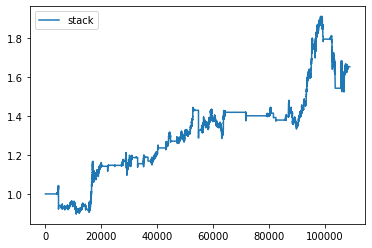

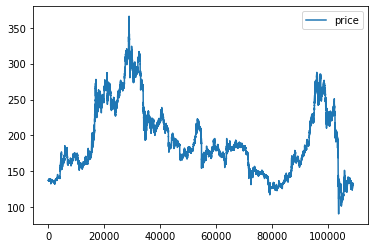

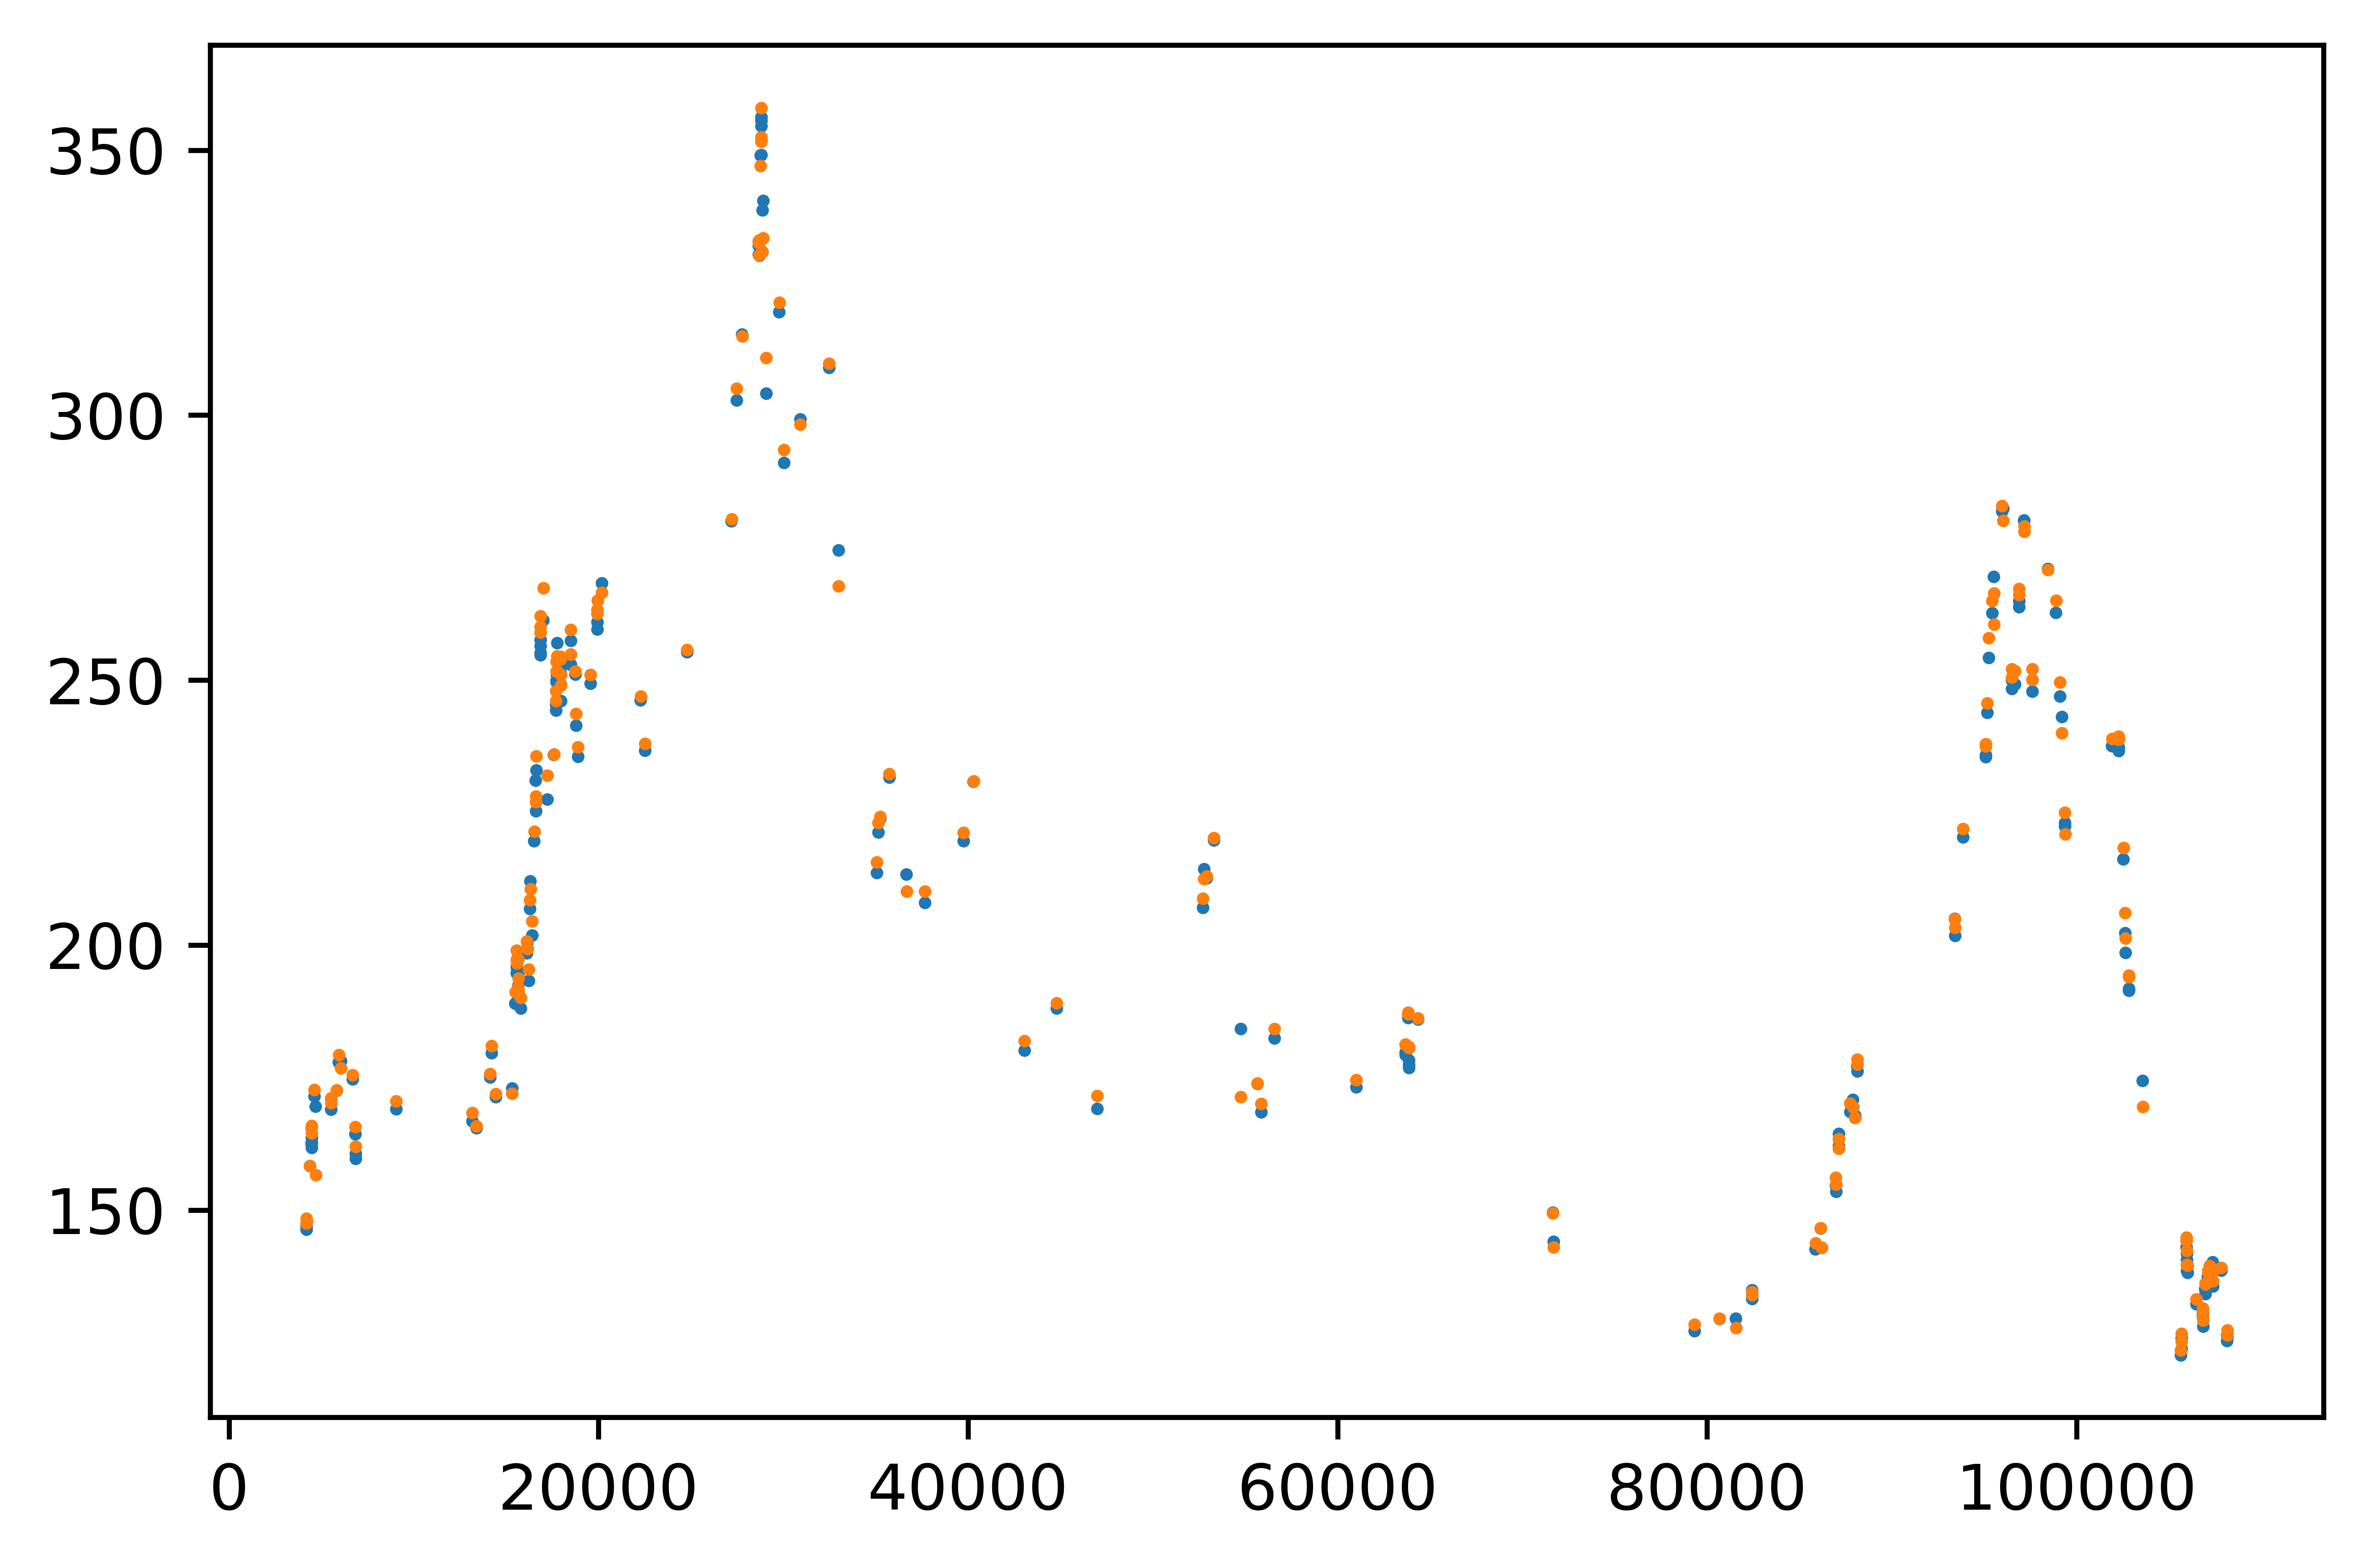

0.0 1.6525917403395518


1.6525917403395518

In [49]:
# test on test data
test_model(test_df.iloc[-20*24*1000:]['open'], test_df.iloc[-20*24*1000:]['high'], test_df.iloc[-20*24*1000:]['low'], predict(estimator2.predict_proba(X_test.iloc[-20*24*1000:])),plot=True)

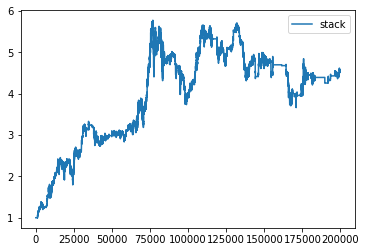

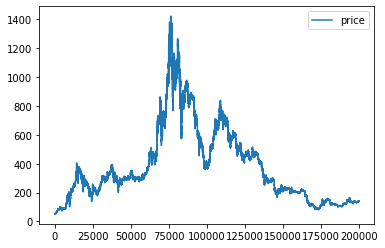

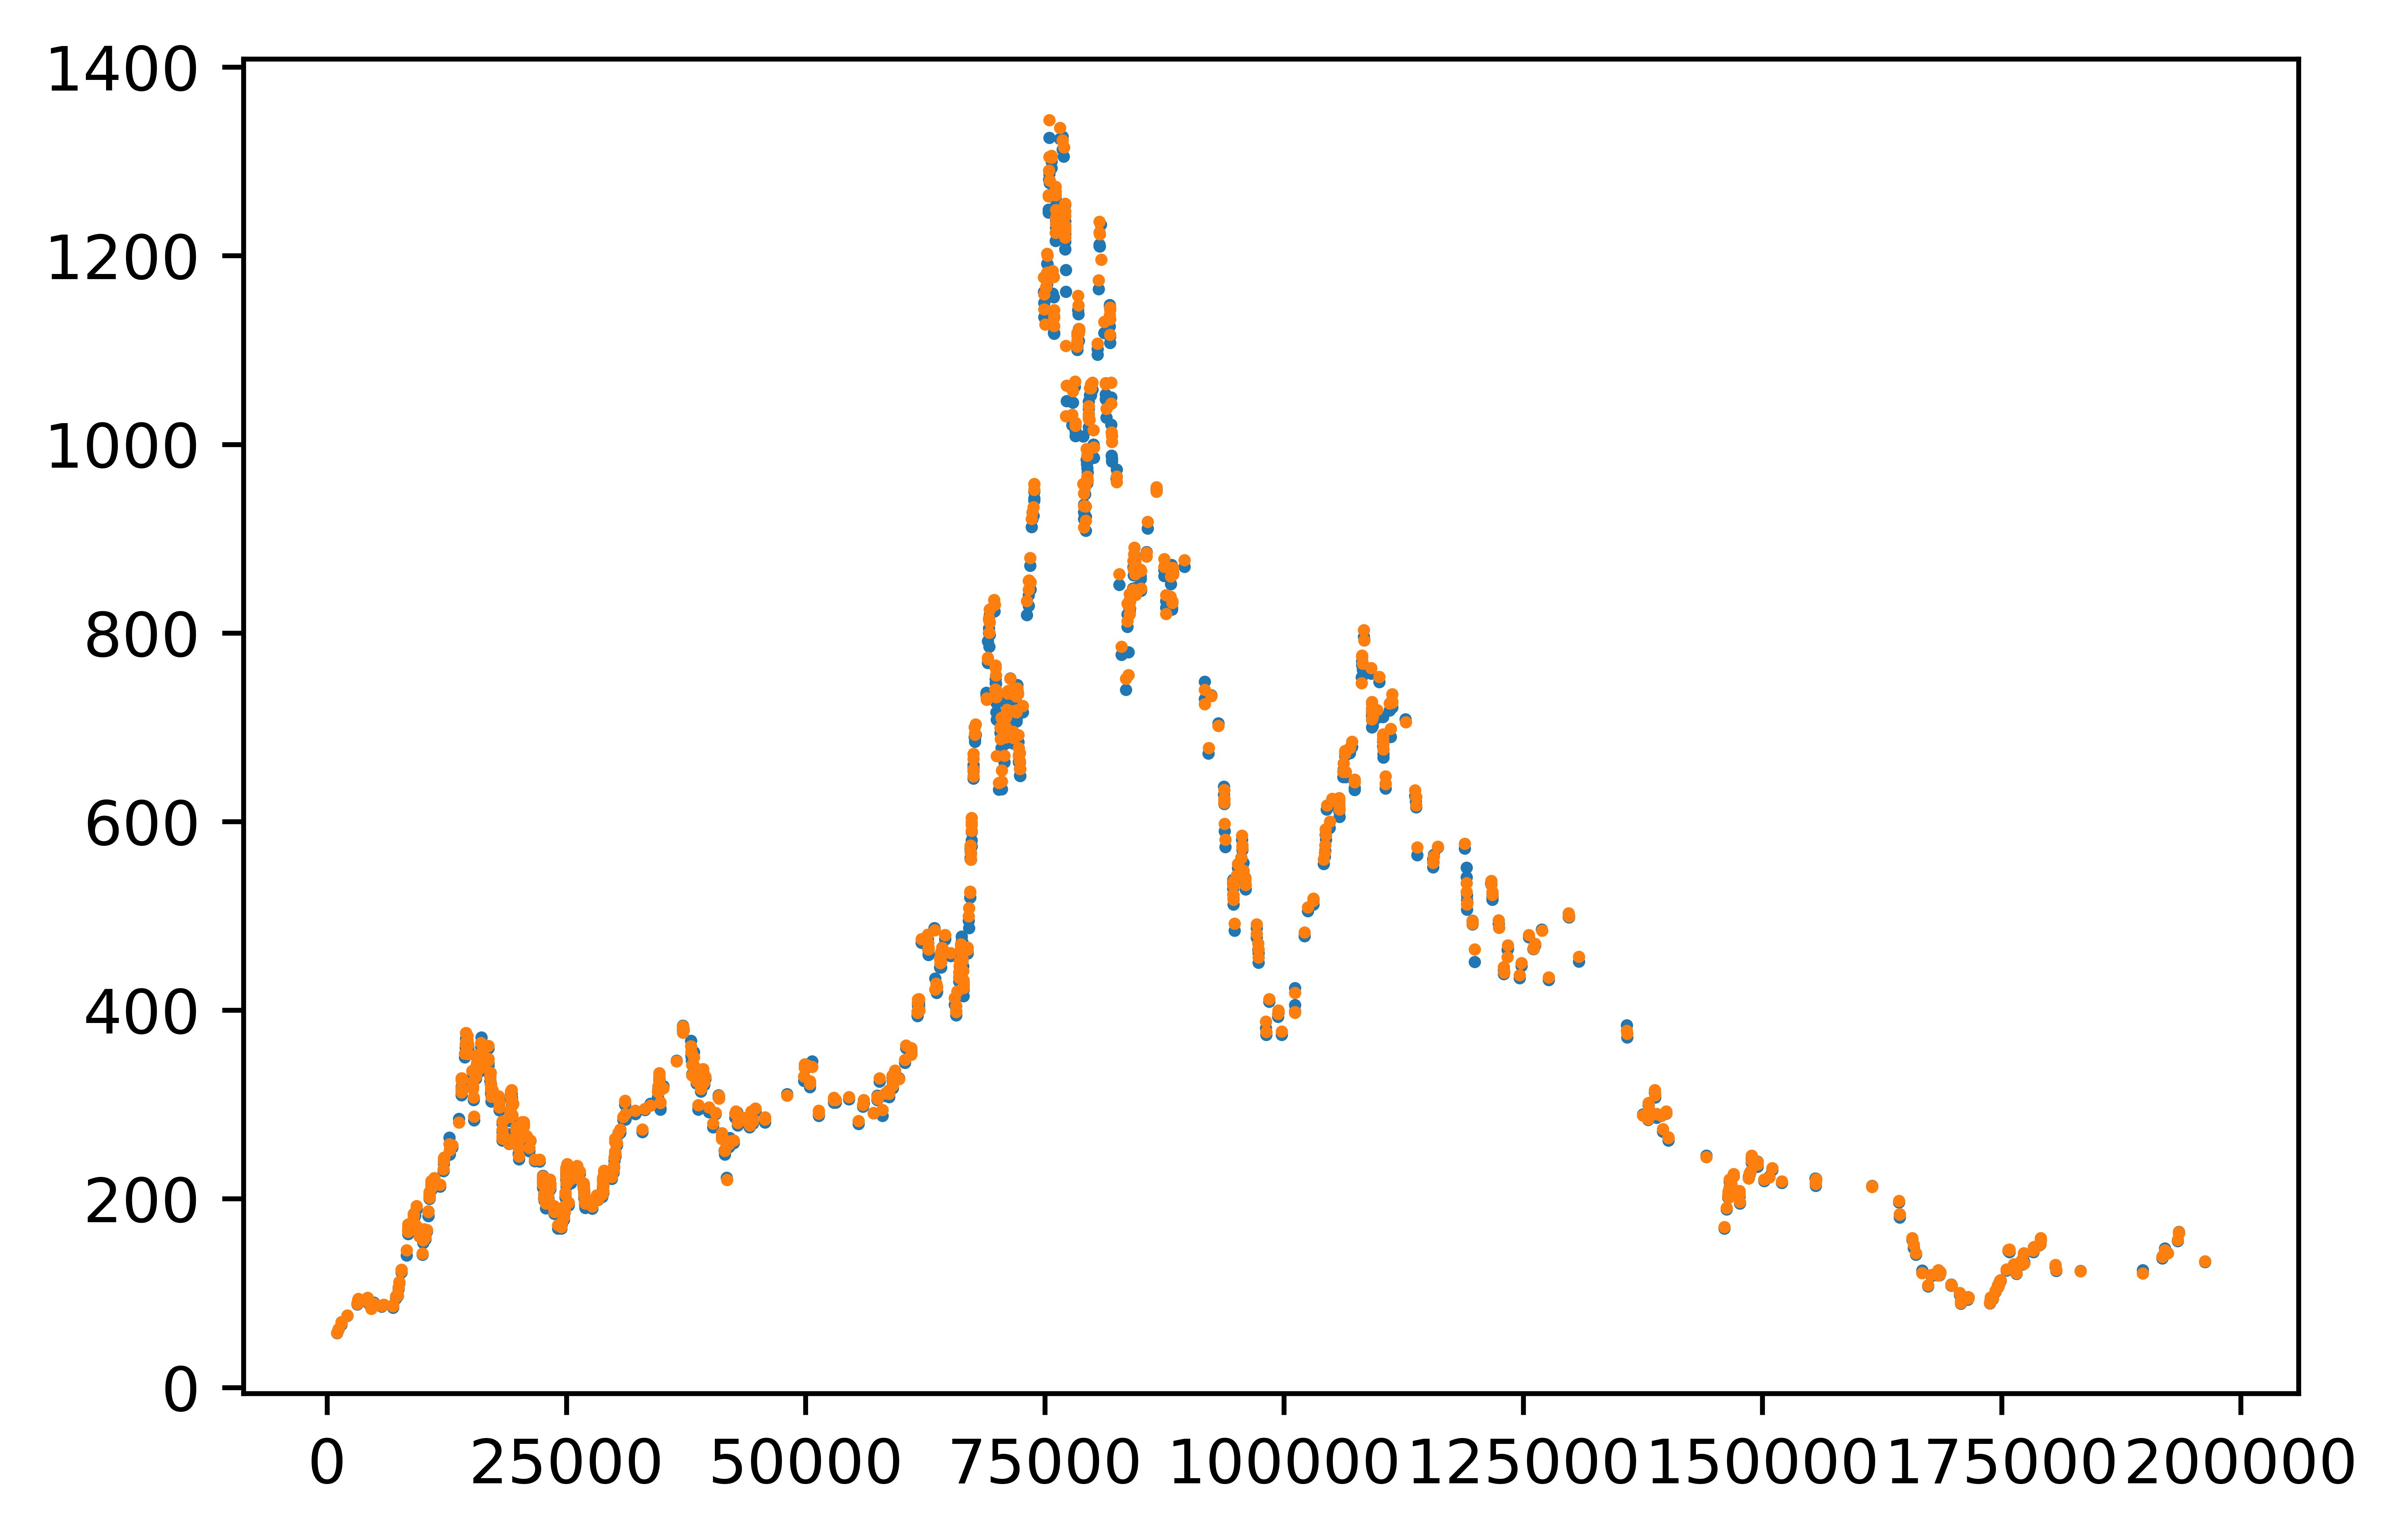

0.016634524893481606 2.224126187914109


4.534661695618704

In [50]:
# test on train data
test_model(train_df.iloc[-20*24*1000:]['open'], train_df.iloc[-20*24*1000:]['high'], train_df.iloc[-20*24*1000:]['low'], predict(estimator2.predict_proba(X_train.iloc[-20*24*1000:])), plot=True)

In [44]:
for price_stop in np.arange(1.005, 1.007, 0.0005):
    for time_stop in range(3,8):
        print(price_stop, time_stop, test_model(train_df.iloc[-20*24*365:]['open'], train_df.iloc[-20*24*365:]['high'], train_df.iloc[-20*24*365:]['low'], predict(estimator2.predict_proba(X_train.iloc[-20*24*365:])), 0.999,sell_stop=price_stop, time_stop=time_stop))

1.005 3 1.5554059769214503
1.005 4 1.5331692169975546
1.005 5 1.7886484686042006
1.005 6 2.0693868459589977
1.005 7 2.019970970422252
1.0054999999999998 3 1.2667980322110621
1.0054999999999998 4 1.2290310405557971
1.0054999999999998 5 1.4207681544186634
1.0054999999999998 6 1.5634483702661721
1.0054999999999998 7 1.6799875433291096
1.0059999999999998 3 1.2919941527384884
1.0059999999999998 4 1.2914844969281836
1.0059999999999998 5 1.5045337711522486
1.0059999999999998 6 1.6863436590857777
1.0059999999999998 7 1.7478375158364123
1.0064999999999997 3 1.1960087453412063
1.0064999999999997 4 1.331114853845406
1.0064999999999997 5 1.4879417443342065
1.0064999999999997 6 1.7447167525979157
1.0064999999999997 7 1.7116014611324473
1.0069999999999997 3 1.4665703338096845
1.0069999999999997 4 1.6731050461355208
1.0069999999999997 5 1.9530771508744866
1.0069999999999997 6 2.149340965624231
1.0069999999999997 7 2.1639548127376917
